In [5]:
!pip install pydicom

In [27]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 


In [28]:
IMAGE_SIZE = 1024
TRAIN_DATA_DIR = '/content/drive/MyDrive/CapstoneProject/data/rsna-pneumonia-detection-challenge/stage_2_train_images'
TEST_DATA_DIR = '/content/drive/MyDrive/CapstoneProject/data/rsna-pneumonia-detection-challenge/stage_2_test_images'
LABEL_DIR = '/content/drive/MyDrive/CapstoneProject/data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv'

In [29]:
def get_file_list(dir):
  file_list = [f for f in  os.listdir(dir)]
  return list(set(file_list))

def parse_dataset(dicom_dir, labels): 
    image_fps = get_file_list(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in labels.iterrows(): 
        fp =row['patientId']+'.dcm'
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [30]:
# training dataset
annotations = pd.read_csv('/content/drive/MyDrive/CapstoneProject/data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv')
annotations.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [31]:
image_fps_list, image_annotations  = parse_dataset(TRAIN_DATA_DIR,annotations)
print(len(image_fps_list))
print(image_fps_list[0])

26684
f9b9749d-3509-4678-bffa-e2c60a3f8384.dcm


In [47]:
TRAIN_IMAGE_COUNT =1000
partial_train_fps = image_fps_list[:TRAIN_IMAGE_COUNT]
sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1 #xhb 20190525
split_index = int((1 - validation_split) * TRAIN_IMAGE_COUNT)

image_fps_train = partial_train_fps[:split_index]
image_fps_val = partial_train_fps[split_index:]

print(len(image_fps_train), len(image_fps_val))

900 100


In [48]:
import numpy as np
import keras
import os
import pydicom
from skimage import io
from skimage import measure
from skimage.transform import resize
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in pneumonia_locations:
            # loop through pneumonia
            for location in pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk.reshape(-1)
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)


In [49]:
import csv
def load(train_label_file_path,filenames):
  pneumonia_locations = {}
  # load table
  with open(train_label_file_path, mode='r') as infile:
      # open reader
      reader = csv.reader(infile)
      # skip header
      next(reader, None)
      # loop through rows
      for rows in reader:
          # retrieve information
          filename = rows[0]
          if(any(ele==(filename+'.dcm')for ele in filenames)!= True):
            continue
          location = rows[1:5]
          pneumonia = rows[5]
          # if row contains pneumonia add label to dictionary
          # which contains a list of pneumonia locations per filename
          if pneumonia == '1':
              # convert string to float to int
              location = [int(float(i)) for i in location]
              # save pneumonia location in dictionary
              if filename in pneumonia_locations:
                  pneumonia_locations[filename].append(location)
              else:
                  pneumonia_locations[filename] = [location]
  return pneumonia_locations

In [50]:
pneumonia_locations = load(LABEL_DIR,image_fps_list)
TARGET_IMAGE_SIZE = 128
pneumonia_locations_train = load(LABEL_DIR, image_fps_train)
pneumonia_locations_val = load(LABEL_DIR, image_fps_val)
print(len(pneumonia_locations))
print(len(pneumonia_locations_train))
print(len(pneumonia_locations_val))

# prepare the training dataset
train_generator = DataGenerator(TRAIN_DATA_DIR, image_fps_train, pneumonia_locations_train,32, TARGET_IMAGE_SIZE)

validation_generator = DataGenerator(TRAIN_DATA_DIR, image_fps_val, pneumonia_locations_val,32, TARGET_IMAGE_SIZE)

6012
203
25


In [51]:
from tensorflow.keras.applications.vgg16 import VGG16
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 

img_input = tf.keras.layers.Input(shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE,1))
img_conc = tf.keras.layers.Concatenate()([img_input, img_input, img_input])  

base_model = VGG16( # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet', input_tensor=img_conc)

In [52]:
for layer in base_model.layers:
    layer.trainable = False

In [53]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [54]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 128, 128, 3)  0           input_3[0][0]                    
                                                                 input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 128, 64) 1792        concatenate_2[0][0]              
______________________________________________________________________________________

In [56]:
model.fit_generator(generator=train_generator, validation_data = validation_generator,  epochs = 10, workers=4)

Epoch 1/10
28/28 [==============================] - 283s 10s/step - loss: 0.1081 - acc: 0.9741 - val_loss: 0.1129 - val_acc: 0.9692
Epoch 2/10
28/28 [==============================] - 279s 10s/step - loss: 0.1071 - acc: 0.9739 - val_loss: 0.1293 - val_acc: 0.9682
Epoch 3/10
28/28 [==============================] - 283s 10s/step - loss: 0.1026 - acc: 0.9728 - val_loss: 0.1336 - val_acc: 0.9663
Epoch 4/10
28/28 [==============================] - 282s 10s/step - loss: 0.1019 - acc: 0.9738 - val_loss: 0.1209 - val_acc: 0.9672
Epoch 5/10
28/28 [==============================] - 285s 10s/step - loss: 0.0978 - acc: 0.9743 - val_loss: 0.1216 - val_acc: 0.9666
Epoch 6/10
28/28 [==============================] - 280s 10s/step - loss: 0.0968 - acc: 0.9740 - val_loss: 0.1200 - val_acc: 0.9663
Epoch 7/10
28/28 [==============================] - 280s 10s/step - loss: 0.0994 - acc: 0.9736 - val_loss: 0.1337 - val_acc: 0.9673
Epoch 8/10
28/28 [==============================] - 281s 10s/step - loss: 0.

In [58]:
model.save('/content/drive/MyDrive/CapstoneProject/model_h5/vgg16.h5')

[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]


IndexError: ignored

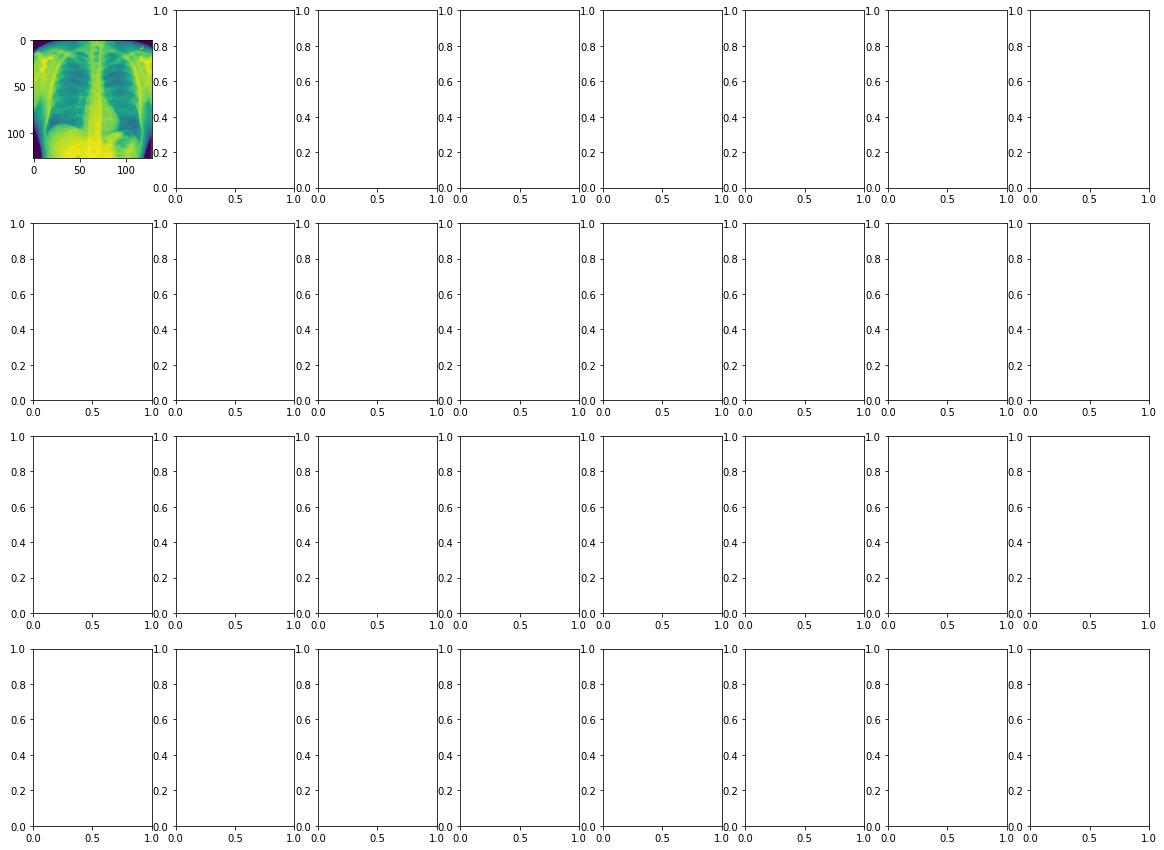

In [69]:
for imgs, msks in validation_generator:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        msk_reshape = np.reshape(msk, img.shape)
        print(msk_reshape)
        # threshold true mask
        comp = msk[:, :] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [62]:
image_fps_test = get_file_list(TEST_DATA_DIR)
test_data_gen = DataGenerator(TEST_DATA_DIR, image_fps_test[:10], None, batch_size=25, image_size=TARGET_IMAGE_SIZE, shuffle=False, predict=True)

In [64]:
# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_data_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

IndexError: ignored

In [60]:
for imgs, filenames in test_data_gen:
    # predict batch of images
    preds = model.predict(imgs)
    print(preds)
    break

[[0.00198665]
 [0.00020704]
 [0.00079742]
 [0.00172731]
 [0.00066206]
 [0.00235927]
 [0.00887623]
 [0.00542057]
 [0.00134203]
 [0.00304875]
 [0.00422502]
 [0.00091073]
 [0.02653593]
 [0.00158665]
 [0.00307205]
 [0.00152773]
 [0.00525868]
 [0.01263916]
 [0.00240132]
 [0.00117838]
 [0.00154483]
 [0.00078928]
 [0.0114581 ]
 [0.01379246]
 [0.03933084]]
